In [1]:
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import umap
import matplotlib.pyplot as plt

/opt/miniconda3/envs/q-eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = "cpu"
model = model.to(device)

In [4]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [2]:
# arr1 = np.load("model_outputs/bf16/93ac8950-a216-4fea-8053-bb7859a9a745/embedding_sequences.npy", allow_pickle=True).item()
# arr2 = np.load("model_outputs/bf16/ec4d81fe-aec3-4aaa-97cd-8d3e0db0225d/embedding_sequences.npy", allow_pickle=True).item()

import glob

# Get list of prompts from prompts.txt
with open('prompts.txt', 'r') as f:
    prompts = [line.strip() for line in f if line.strip()]

# Load embedding files in order matching prompts
arrays = []
for prompt in prompts:
    # Find matching file for this prompt
    matching_files = glob.glob(f"model_outputs/1B/bf16/*{prompt}*/embedding_sequences.npy")
    if matching_files:
        arr = np.load(matching_files[0], allow_pickle=True).item()
        arrays.append(arr)

/opt/miniconda3/envs/q-eval/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/q-eval/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


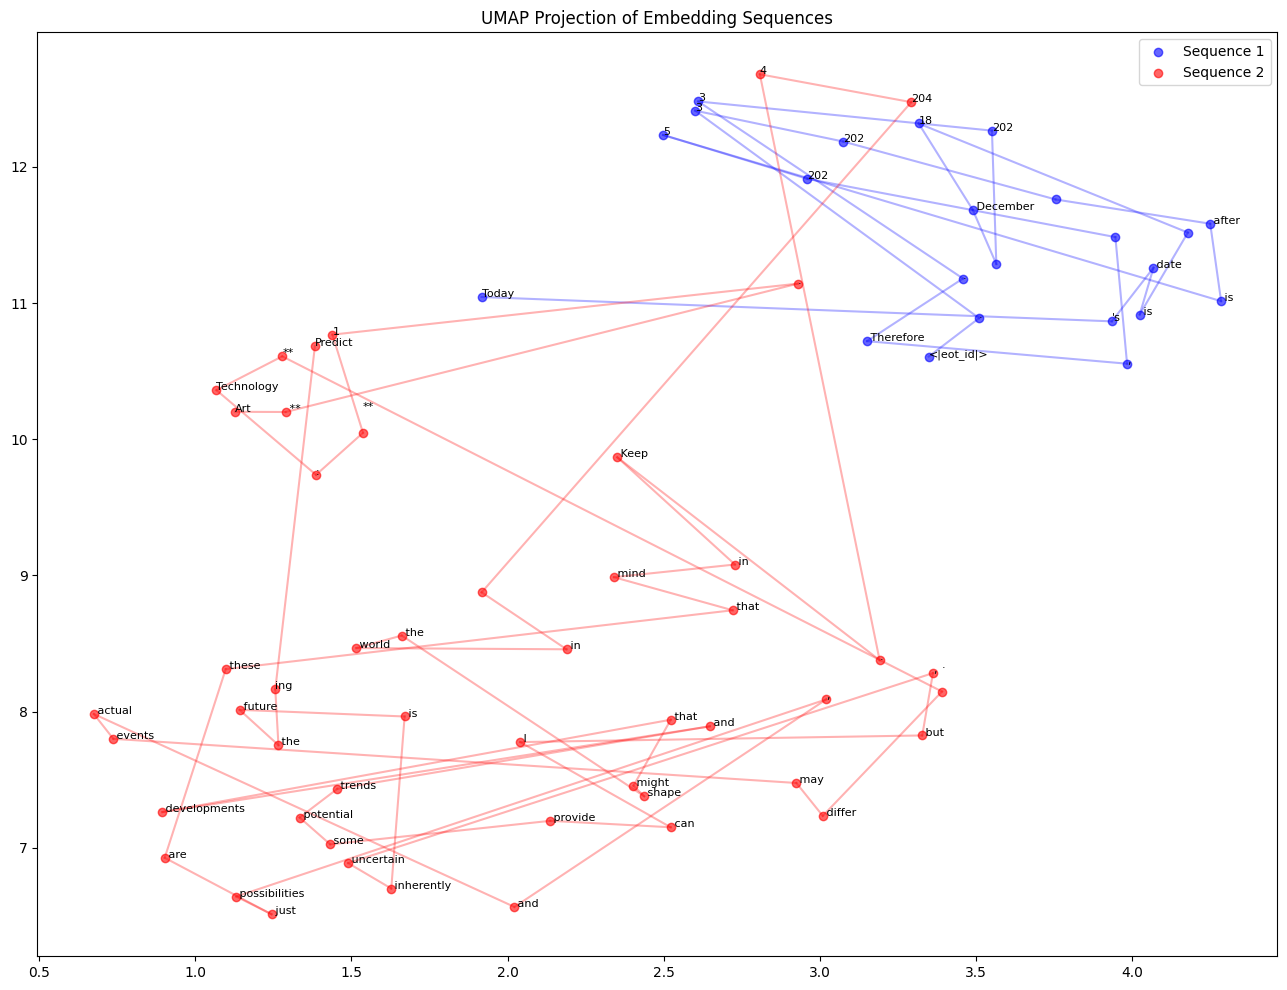

In [4]:
arr1, arr2 = arrays[:2]

# Initialize UMAP
reducer = umap.UMAP(random_state=42)

# Combine embeddings for joint dimensionality reduction
combined_embeddings = np.vstack([arr1['embeddings'], arr2['embeddings']])
reduced_embeddings = reducer.fit_transform(combined_embeddings)

# Split back into separate arrays
n_arr1 = len(arr1['embeddings'])
reduced_arr1 = reduced_embeddings[:n_arr1]
reduced_arr2 = reduced_embeddings[n_arr1:]

# Create plot
plt.figure(figsize=(16, 12))

# Plot points and connections for arr1
plt.scatter(reduced_arr1[:, 0], reduced_arr1[:, 1], c='blue', label='Sequence 1', alpha=0.6)
for i in range(len(reduced_arr1)-1):
    plt.plot(reduced_arr1[i:i+2, 0], reduced_arr1[i:i+2, 1], 'b-', alpha=0.3)
    
# Add labels for arr1 points
for i, txt in enumerate(arr1['token_strings']):
    plt.annotate(txt, (reduced_arr1[i, 0], reduced_arr1[i, 1]), fontsize=8)

# Plot points and connections for arr2
plt.scatter(reduced_arr2[:, 0], reduced_arr2[:, 1], c='red', label='Sequence 2', alpha=0.6)
for i in range(len(reduced_arr2)-1):
    plt.plot(reduced_arr2[i:i+2, 0], reduced_arr2[i:i+2, 1], 'r-', alpha=0.3)

# Add labels for arr2 points    
for i, txt in enumerate(arr2['token_strings']):
    plt.annotate(txt, (reduced_arr2[i, 0], reduced_arr2[i, 1]), fontsize=8)

plt.title('UMAP Projection of Embedding Sequences')
plt.legend()
plt.show()

/opt/miniconda3/envs/q-eval/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/q-eval/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/mt/fp8n9l6d6j34jjmbv468f8mm0000gn/T/ipykernel_70266/3849252737.py:58: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig("embedding_sequences.png")
/opt/miniconda3/envs/q-eval/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


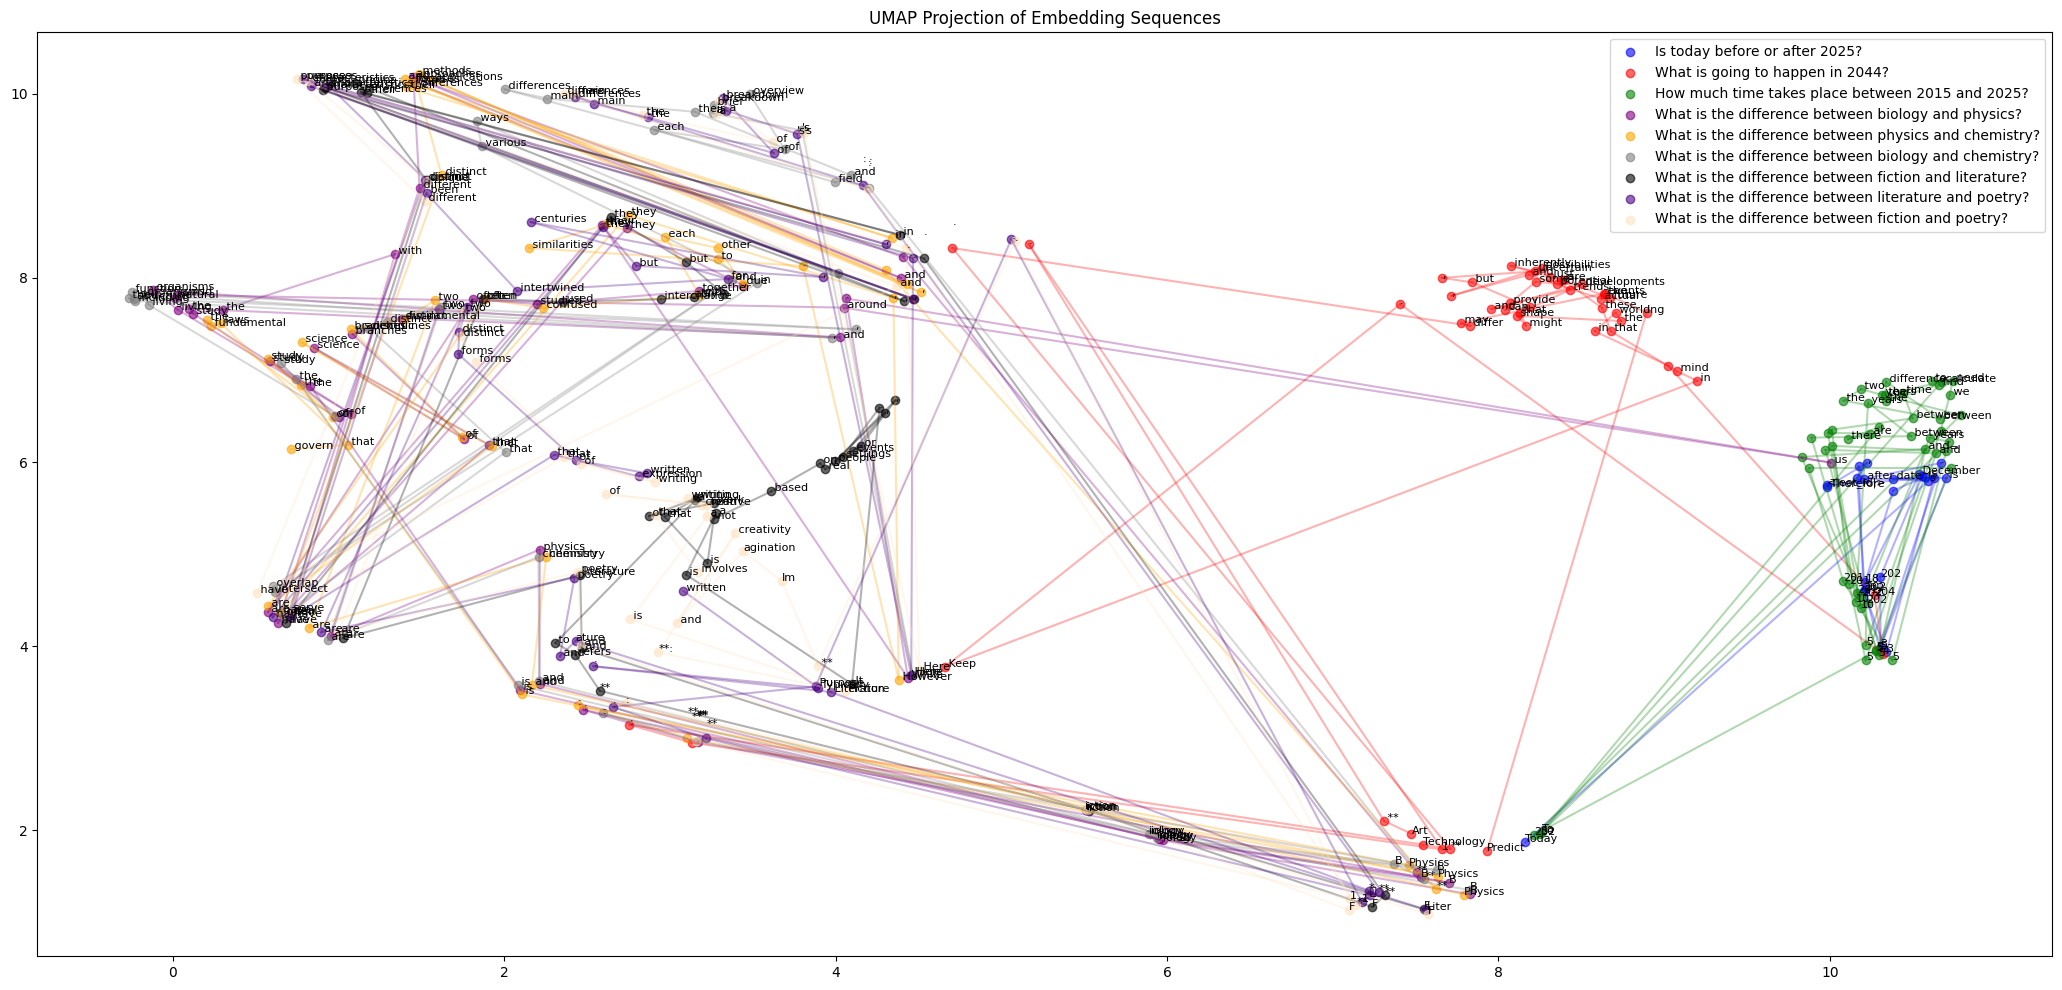

In [35]:
def create_umap_projection(embeddings_list, random_state=42):
    """Create UMAP projection for a list of embedding arrays."""
    # Combine all embeddings
    combined_embeddings = np.vstack([arr['embeddings'] for arr in embeddings_list])
    
    # Initialize and fit UMAP
    reducer = umap.UMAP(random_state=random_state)
    reduced_embeddings = reducer.fit_transform(combined_embeddings)
    
    # Split back into separate arrays
    splits = np.cumsum([len(arr['embeddings']) for arr in embeddings_list])[:-1]
    return np.split(reduced_embeddings, splits)

def plot_embedding_sequences(prompts, embedding_arrays, figsize=(26, 12)):
    """Plot multiple sequences of embeddings with their connections and labels.
    
    Args:
        embedding_arrays: List of dicts, each containing 'embeddings' and 'token_strings'
        figsize: Tuple specifying figure dimensions
    """
    # Get UMAP projections
    reduced_sequences = create_umap_projection(embedding_arrays)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Define colors
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'grey', 'black', 'indigo', 'bisque']
    
    # Plot each sequence
    for idx, (reduced_arr, arr) in enumerate(zip(reduced_sequences, embedding_arrays)):
        color = colors[idx % len(colors)]
        
        # Plot points
        plt.scatter(
            reduced_arr[:, 0], 
            reduced_arr[:, 1], 
            c=color,
            label=prompts[idx], 
            alpha=0.6
        )
        
        # Plot connections
        for i in range(len(reduced_arr)-1):
            plt.plot(
                reduced_arr[i:i+2, 0], 
                reduced_arr[i:i+2, 1], 
                c=color,
                alpha=0.3
            )
        
        # Add labels
        for i, txt in enumerate(arr['token_strings']):
            plt.annotate(txt, (reduced_arr[i, 0], reduced_arr[i, 1]), fontsize=8)
    
    plt.title('UMAP Projection of Embedding Sequences')
    plt.legend()
    plt.savefig("embedding_sequences.png")
    plt.show()

# Example usage:
plot_embedding_sequences(prompts, arrays)